# Network inference via physics heuristics
We are aiming to investigate the information boundaries of community detection via the implementation of physics heuristics.

Firstly we will import all the libraries we will be using, most of theses will be standard functions

In [57]:
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### Stochastic Block Model definition
First we use create a class defining our stochastic block model, we will be storing the graph produced as a adjacency list as it will allow us to look up the neighbours of each vertex very quickly which is what we will mostly be doing.

In [58]:
class SBM:
    def __init__(self,c_in, c_out, no_groups, size) -> None:
        self.q = no_groups
        self.n = size
        self.p_in = c_in/size
        self.p_out = c_out/size
        self.node_groups = dict()
        self.group_colouring = [[rnd.random(),rnd.random(),rnd.random()] for i in range(self.q)]

    def generate(self) -> None:
        adj_list = [[] for i in range(self.n)]
        for i in range(self.n):
            rand = rnd.randint(0,self.q-1)
            self.node_groups[i]=rand

        adj_matrix = np.zeros((self.n,self.n))

        for i in range(self.n):
            for j in range(i+1,self.n):
                rand = rnd.random()
                if(self.node_groups[i] == self.node_groups[j] and rand<=self.p_in):
                    adj_list[i].append(j)
                    adj_list[j].append(i)
                    adj_matrix[i][j] =1
                    adj_matrix[j][i] =1
                elif(self.node_groups[i] != self.node_groups[j] and rand<= self.p_out):
                    adj_list[i].append(j)
                    adj_list[j].append(i)
                    adj_matrix[i][j] =1
                    adj_matrix[j][i] =1
        self.adj_matrix = adj_matrix
        self.adj_list = adj_list

    def displayGroup(self,colouring):
        fig, (ax1,ax2) = plt.subplots(1,2,figsize = (10,5))

        g= nx.from_numpy_array(self.adj_matrix)
        pos = nx.random_layout(g)
        color_map = [self.group_colouring[colouring[i]-1] for i in range(self.n)]
        ground_truth_map = [self.group_colouring[self.node_groups[i]-1] for i in range(self.n)]

        fig.suptitle("Ground Truth vs Extracted communities")
        nx.draw(g,node_color=color_map,with_labels = True,ax= ax1,pos=pos)
        nx.draw(g,node_color=ground_truth_map,with_labels = True,ax= ax2, pos=pos)
        plt.show()

## Belief Propagation
We will be updating marginals with the following equation corresponding to the marginal that vertex $i$ is in group $r$:
$$
\psi_r^i \propto \prod_{j;(i,j)\in E} \sum_{s=1}^q \psi_s^{j \to i}p_{rs} \\
\psi_r^{i \to j} \propto \prod_{\substack{k;(i,k)\in E \\ k\neq j}} \sum_{s=1}^q \psi_s^{k \to i}p_{rs} 
$$
where $p_{rs}$ is the probability a vertex is in group $r$ while its neighbour is in group $s$. In our cases all these probabilities will be the same.
We will start by setting up the starting marginals for each group and vertex to be equal to $0.5 \pm r\alpha$ where $\alpha$ is some constant determining a natural variance and $r$ denotes a random number in the interval $(0,1)$

In [59]:
def beliefPropagation(graph):
    marginals= beliefPropagation(graph, rnd.randint(0,graph.n-1),[])
    colouring = dict()

    for v in range(graph.n):

        i = np.argmax(marginals)
        colouring[v] = i
    return colouring
        

def beliefPropagation(graph,v,marginals):
    end = False
    alpha = 0.1
    p=0.5
    v_marginal = 1
    for u in graph.adj_list[v]:
        if(not marginals[u]):
            end = True
            output_marginals = beliefPropagation(graph,u,marginals)
            for i in range(len(output_marginals)):
                if(not output_marginals[i]):
                    marginals[i] = output_marginals[i]
            
        v_marginal *= marginals[u] *p
    
    if(end):
        v_marginal = [0.5 + alpha * rnd.random() for i in range(graph.q)]
    
    v_marginal = [float(i)/sum(v_marginal) for i in v_marginal]
    marginals[v] = v_marginal
    return marginals



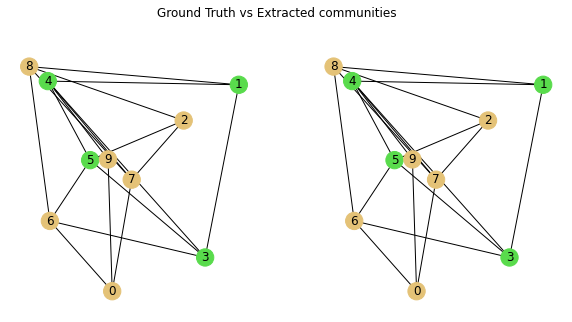

In [60]:
test= SBM(5,3,2,10)
test.generate()
test.displayGroup(test.node_groups)